# Description
This will focus on time series analysis. 
From the learned betas, I will do further analysis of how the infered variables vary by region, etc.
# Imports

In [3]:
# data wrangling
import numpy as np
import pandas as pd
import os.path

# viz
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# modeling
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as smt
import statsmodels.graphics as smg

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
!pip install tensorflow
# documentation  = https://matrixprofile.docs.matrixprofile.org/examples/NYC_Taxis.html
!pip install matrixprofile
    

  Using cached tensorflow-2.2.0-cp38-cp38-win_amd64.whl (459.2 MB)


ERROR: Could not install packages due to an EnvironmentError: [Errno 28] No space left on device



[example notebook: link](https://github.com/gakhov/pycon-ua-2018/blob/master/stochastic-models.ipynb)

In [4]:
def mask(df, col, value):
    """low-overhead method similar to .query()"""
    return df[df[col] == value]
pd.DataFrame.mask = mask

# Parameters

In [5]:
alt.renderers.enable(embed_options={'theme': 'vox'})
alt.data_transformers.disable_max_rows()
plt.style.use('seaborn')

# Load Data

In [6]:
all_data_path = r'../../data/snow_data_clean.pkl'

In [7]:
long_series_df = pd.read_pickle(all_data_path)

## Split Data

# Plotting Functions
* ACF, PACF, etc.  
* residuals over time
* y vs yhat
* train & extrapolate



In [9]:
def AC_plotter(df, lags):
    ac_plot = smg.tsaplots.plot_acf(x=df.base,
                                    ax=None, lags=lags, alpha=0.05, 
                                    use_vlines=True, unbiased=False,
                                    missing='conservative',
                                    title=f'Autocorrelation: lag of {lags}', 
                                    zero=True,
                                   )
    ac_plot;

# Timeseries Modeling

The evolution of snow base depth over time depends (not 1:1; a foot of powder is only a few inches of packed powder) on new snowfall and melting of old snow. I will start by modeling as a simple timeseries, and then include new snowfall as a predictor variable.
## ARIMA and extensions

There is clear seasonality so I will specify a Seasonal autoregressive integrated moving average model. I will start with the combined timeseries for the Colorado ski mountains.

In [8]:
co_base_ts = (long_series_df
              .query('region=="Colorado"')
              [['base', 'pseudo_ts']]
              .sort_values(by='pseudo_ts')
             )
TimeSeriesSplit()

TimeSeriesSplit(max_train_size=None, n_splits=5)

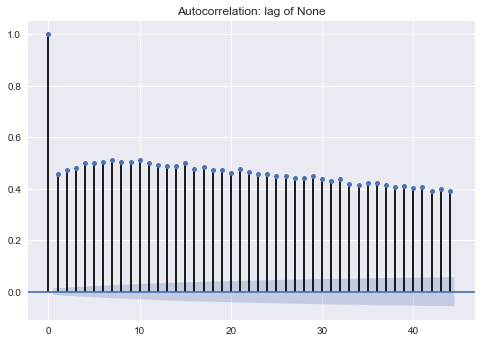

In [10]:
AC_plotter(co_base_ts, None)

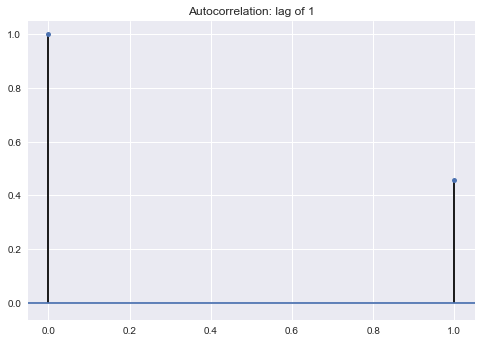

In [11]:
AC_plotter(co_base_ts, 1)

I will use differencing order of 1. There may be a trend do to sequence the mountains were concatenated in.

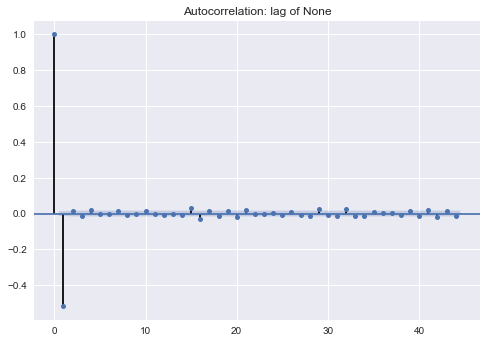

In [12]:
co_base_ts_l1 = co_base_ts.diff(1)
AC_plotter(co_base_ts_l1, None)

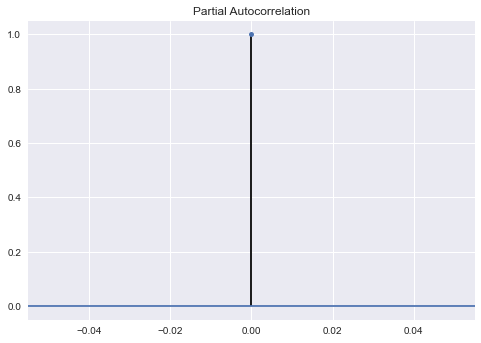

In [13]:
pac_plot = smg.tsaplots.plot_pacf(x=co_base_ts_l1.base, ax=None, lags=1,
                       alpha=0.05, method='ywunbiased', use_vlines=True, 
                       title='Partial Autocorrelation', zero=True, 
                       vlines_kwargs=None,)
pac_plot;

I will add one MA term because of the slight negative correlation on the differenced series on the first lag.

In [14]:
co_base_ts_valuearr = co_base_ts.values[:,0].astype(np.single)

In [15]:
 # (p, d, q) | (AR, diff, MA) ; need to slice values to get rid of ts data
arima_model = smt.arima.model.ARIMA(endog=co_base_ts_valuearr, order=(0, 1, 1))
arima_model_fit = arima_model.fit()

In [16]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                22993
Model:                 ARIMA(0, 1, 1)   Log Likelihood             -100721.834
Date:                Mon, 25 May 2020   AIC                         201447.669
Time:                        03:23:08   BIC                         201463.754
Sample:                             0   HQIC                        201452.896
                              - 22993                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9160      0.002   -417.950      0.000      -0.920      -0.912
sigma2       388.0743      2.359    164.487      0.000     383.450     392.698
===================================================================================
Ljung-Box (Q):                      585.46   Jarque-Bera (JB):             10495.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

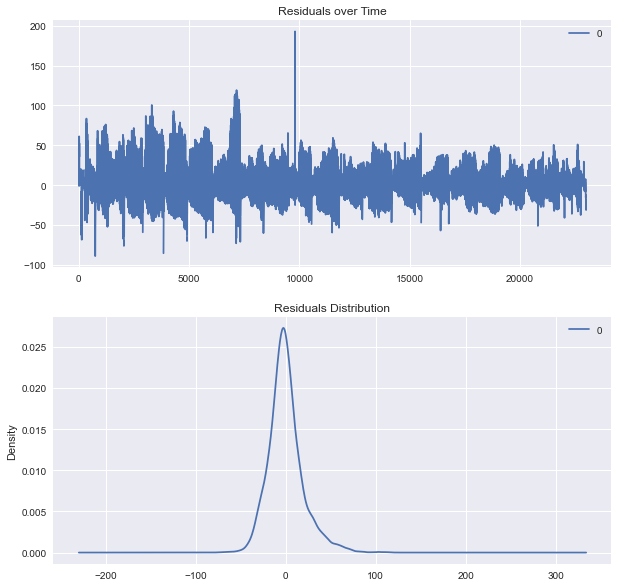

                  0
count  22894.000000
mean       0.005547
std       19.704289
min      -89.183930
25%      -11.674744
50%       -1.813023
75%        8.988866
max      192.880937


In [17]:
def resid_plotter(residuals=None, y=None):
    """plot residual errors"""
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
    residuals.plot(title="Residuals over Time", ax=ax1)
    residuals.plot(kind='kde', title="Residuals Distribution", ax=ax2)
    plt.show()
    print(residuals.describe())
arima_resids = pd.DataFrame(arima_model_fit.resid)
resid_plotter(arima_resids)

there does not appear to be a trend. The errors are not exactly normal. The residuals vary cyclicly so an ARCH  model may be useful.

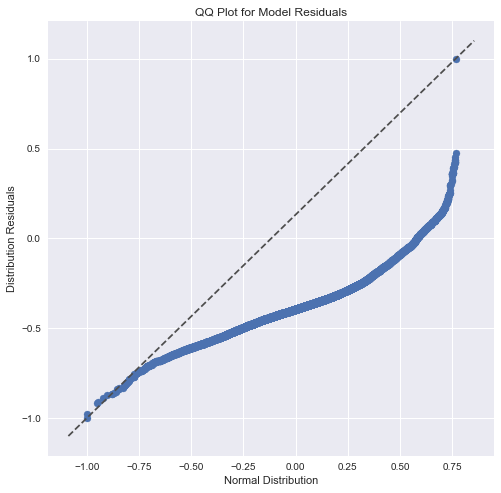

In [18]:
def resid_qqer(residuals):
    size = residuals.shape[0]
    normal = np.random.normal(0, .1, size)
    
    #scale data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    residuals = scaler.fit_transform(residuals.sort_values(by=0))
    normal.sort()
    normal = normal.reshape(-1, 1)
    normal = scaler.fit_transform(normal)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = plt.scatter(x=normal, y=residuals)
    #plt.plot(normal, residuals, "o")
    plt.xlabel('Normal Distribution')
    plt.ylabel('Distribution Residuals')
    plt.title('QQ Plot for Model Residuals')
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
    #plt.plot([0, 1], [0, 1], transform=ax.transAxes)
    plt.show()
resid_qqer(arima_resids)

In [19]:
def y_and_yhat_plotter(model=None, endog=None, query_filter=None, date_between=None):
    """endog should be df with time series data and pseudo_ts"""
    df = endog.copy()
    df.columns = ['y', 'pseudo_ts']
    yhat = model.fit().predict()
    df['yhat'] = yhat
    if query_filter:
        df = df.query(query_filter)
    if date_between:
        df = df.loc[df.pseudo_ts.between(*date_between)]
    df = df.melt(value_vars=['y', 'yhat'], id_vars=['pseudo_ts'])
    fig, ax = plt.subplots(figsize=(18, 6))
    sns.lineplot(data=df, x='pseudo_ts', y='value', hue='variable')
    plt.show();

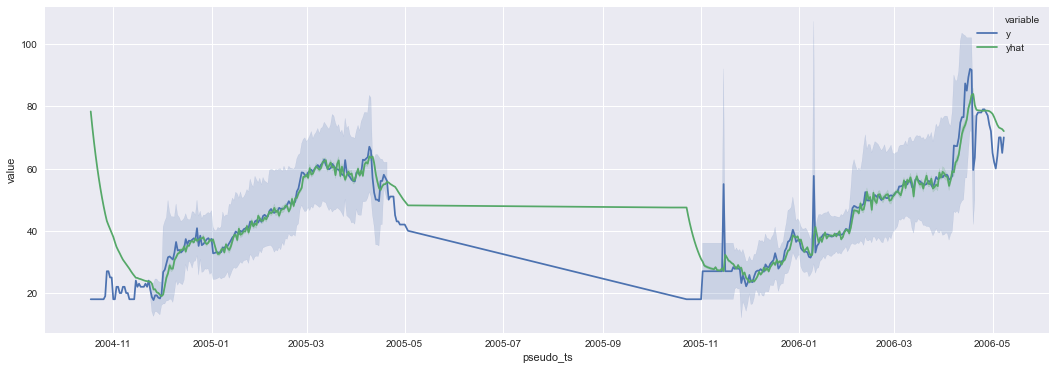

In [20]:
start_d, end_d = '2004-08-01', '2006-07-30'
y_and_yhat_plotter(arima_model, co_base_ts, 
                   query_filter='pseudo_ts>@start_d & pseudo_ts<@end_d')

this looks somewhat over-dispersed.

### SARIMA
There should not be any relationship between years (absent modeling climate-level dependencies e.g. El Niño cycles, so I will do a simple 1 years differencing.

In [21]:
sarima_model = smt.arima.model.ARIMA(endog=co_base_ts_valuearr, order=(0, 1, 1),
                                    seasonal_order=(0, 1, 0, 365))
sarima_model_fit = sarima_model.fit()

MemoryError: Unable to allocate 23.2 GiB for an array with shape (368, 368, 22994) and data type float64

ARIMAX using snowfall data with powder -> packed powder and melt inference

#### Other models
GARCH, Gaussian Process, hidden Markov

### Bayesian Structural Model
[example bsm in R](https://multithreaded.stitchfix.com/blog/2016/04/21/forget-arima/),  
[use tensorflow probability](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html),  
[tfp example notebook: link](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb),  

### Panel Models
Linearmodels module?

# TF LSTM models


# Prophet models